In [1]:
import os
import pandas as pd
import numpy as np
import yaml
import logging
import pickle
from sklearn.metrics import r2_score
from scipy.stats import t
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from utilities.utilities import read_ac_data, add_gdp_cdd_data

In [2]:
# Load configuration from config.yaml
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)

# Set logging level
logging.basicConfig(level=config["logging_level"])

if not os.path.exists('Figures/exposure_function') :
    os.makedirs('Figures/exposure_function')

In [3]:
# Read the air conditioning data from the EIA and GDL

# EIA data of AC access from 2018
ac_data_eia = read_ac_data(config['ac_historical_file_iea'], 2018, skip=3)

# GDL data from multiple years
ac_data_gdl = read_ac_data(config['ac_historical_file_gdl'])

# Read OECD data
ac_data_oecd = read_ac_data(config['ac_historical_file_oecd'], 2011)

# Merge the two dataframes
ac_data = pd.concat([ac_data_oecd, ac_data_gdl, ac_data_eia])

ac_data = add_gdp_cdd_data(ac_data, config)

ac_data["GDP"] = pd.to_numeric(ac_data["GDP"], errors='coerce')

# If there are multiple entries for the same country, only keep the latest one
ac_data = ac_data.drop_duplicates('ISO3', keep='last')
ac_data = ac_data.dropna()

# Save the data to a csv file
ac_data.to_csv("air_conditioning_data.csv")

# Prepare xdata as a tuple of CDD and GDP, ydata as AC
xdata = (ac_data["CDD"]/1e3, ac_data["GDP"]/1e6)
ydata = ac_data["AC"]


In [4]:
# Functional form of AC access as proposed in this study
def ac_access_combined_exp(xdata, a, b, c):
    cdd, gdp = xdata
    return (1. - np.exp(-a * ((cdd)**(b*gdp) * (gdp)**c)))

In [5]:
def r2_step_by_step(ydata, ymodel):
    """
    Calculate R2 step by step
    """
    ss_res = np.sum((ydata - ymodel)**2)
    ss_tot = np.sum((ydata - np.mean(ydata))**2)
    r2_step = 1 - ss_res/ss_tot
    return r2_step

def compute_log_likelihood(rss, n):
    """
    Compute the log likelihood function
    """
    s = np.sqrt(rss / n)
    llf = - n/2 * np.log(2 * np.pi) - \
            n * np.log(s) - 1/(2 * s**2) * rss
    return llf

def computeAIC(ydata, ymodel, k):
    """
    Compute the Akaike Information Criterion
    """
    n = len(ydata)
    rss = np.sum((ydata - ymodel)**2)
    aic = -2 * compute_log_likelihood(rss, n) + 2 * k
    # Bias correction
    aic += 2 * k * (k + 1) / (n - k - 1)
    return aic

def t_test(ydata, params, cov):
    """
    Perform a t-test on the model
    """
    stderr = np.sqrt(np.diag(cov))
    t_vals = params / stderr
    df = len(ydata) - len(params)
    p_vals = [2 * (1 - t.cdf(np.abs(t_val), df)) for t_val in t_vals]
    return t_vals, p_vals

In [6]:
def fit_diagnostics(ydata, ymodel, params, cov, funct_name=''):
    """
    Calculate R2 with function and step by step
    """
    print("Fit diagnostics for ", funct_name)
    r2 = r2_score(ydata, ymodel)
    print("R^2: ", r2)
    
    r2_step = r2_step_by_step(ydata, ymodel)
    print("R^2 step-by-step: ", r2_step)

    if cov is not None:
        print("Std. Err: ", np.sqrt(np.diag(cov)))
        t_values, p_values = t_test(ydata, params, cov)
        print("t-values", t_values)
        print("p-values", p_values)

    aic = computeAIC(ydata, ymodel, len(params))
    print("AIC: ", aic)

In [7]:
# Plot AC access data vs model
def plot_ac_access(ydata, ymodel, color, title, filename):
    plt.figure()
    plt.scatter(ydata, ymodel, color=color)
    plt.plot([0.001, 1], [0.001, 1], color='gray', linestyle='--')
    # Both axes in log scale
    plt.xscale('log')
    plt.yscale('log')
    # Set the limits of the axes
    plt.xlim([0.001, 1])
    plt.ylim([0.001, 1])
    # Add labels
    plt.xlabel("AC access data")
    plt.ylabel("AC access model")
    plt.title(title)
    plt.savefig("Figures/exposure_function/{0}.png".format(filename))

Fit parameters for AC access combined exponential
alpha =  54.93957438654128 beta =  8.765158071933847 gamma =  1.2779354974735944 

Fit diagnostics for  AC access combined exponential
R^2:  0.5411568331519235
R^2 step-by-step:  0.5411568331519235
Std. Err:  [36.97948594  2.70184651  0.17434901]
t-values [1.48567707 3.2441362  7.32975464]
p-values [0.14167056920051424, 0.0017784049366447174, 2.537214882636363e-10]
AIC:  -59.6616755646806


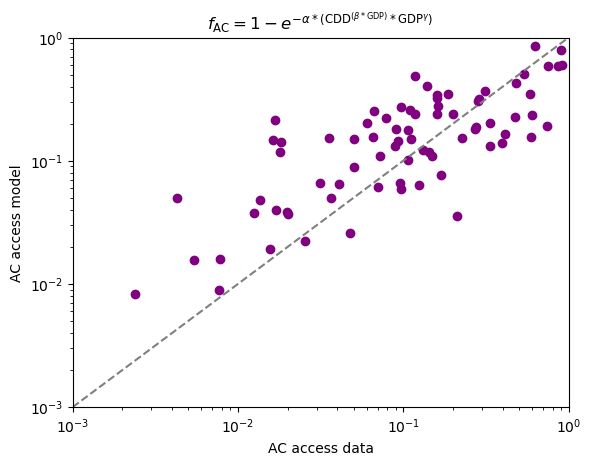

In [8]:
# Fit with new function
popt_comb, pcov_comb = curve_fit(ac_access_combined_exp, xdata, ydata, bounds=(0, np.inf))
print("Fit parameters for AC access combined exponential")
print("alpha = ", popt_comb[0], "beta = ", popt_comb[1], "gamma = ", popt_comb[2], "\n")

# Calculate fit diagnostics
fit_diagnostics(ydata, ac_access_combined_exp(xdata, *popt_comb), popt_comb, pcov_comb, "AC access combined exponential")
# Plot the AC access data vs model
plot_ac_access((ydata), (ac_access_combined_exp(xdata, *popt_comb)), "purple", r"$f_{\mathrm{AC}}=1 - e^{-\alpha * (\mathrm{CDD}^{(\beta*\mathrm{GDP})} * \mathrm{GDP}^{\gamma})}$", "ac_access_combined_exp")

with open('exposure_function_params_combined_exponential.pkl', 'wb') as f:
    pickle.dump({'alpha': popt_comb[0], 'beta': popt_comb[1], 'gamma': popt_comb[2]}, f)

Fit parameters for AC access combined exponential
alpha =  82.36611206057836 beta =  5.5090469894509 gamma =  1.3510118846068546 

Fit diagnostics for  AC access log of combined exponential
R^2:  0.5495848650609942
R^2 step-by-step:  0.5495848650609942
Std. Err:  [45.85714295  1.65402969  0.16982907]
t-values [1.79614574 3.33068205 7.95512737]
p-values [0.07660888501797691, 0.001361233005394924, 1.7098544802252036e-11]
AIC:  53.52095366392964


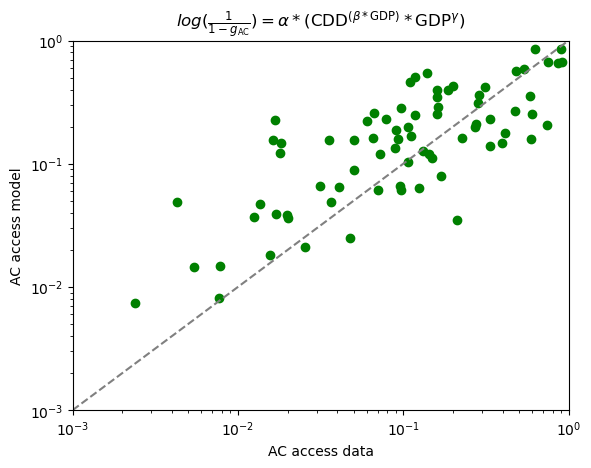

In [9]:
# Repeat the fit with the log of the function

def ac_access_log(xdata, a, b, c):
    cdd, gdp = xdata
    return (a * ((cdd)**(b*gdp) * (gdp)**c))

popt_comb_log, pcov_comb_log = curve_fit(ac_access_log, xdata, np.log(1/(1-ydata)), bounds=(0, np.inf))
print("Fit parameters for AC access combined exponential")
print("alpha = ", popt_comb_log[0], "beta = ", popt_comb_log[1], "gamma = ", popt_comb_log[2], "\n")

# Calculate fit diagnostics
fit_diagnostics(np.log(1/(1-ydata)), ac_access_log(xdata, *popt_comb_log), popt_comb_log, pcov_comb_log, "AC access log of combined exponential")
# Plot the AC access data vs model
plot_ac_access((ydata), (1.-np.exp(-1*ac_access_log(xdata, *popt_comb_log))), "green", r"$log(\frac{1}{1-g_{\mathrm{AC}}})= \alpha * (\mathrm{CDD}^{(\beta*\mathrm{GDP})} * \mathrm{GDP}^{\gamma})$", "ac_access_combined_exp_log")


Fit parameters for AC access combined exponential
alpha =  56.96087187793214 beta =  8.453563635753994 gamma =  1.3487582516599315 

Fit diagnostics for  AC access double log of combined exponential
R^2:  0.6028477317084985
R^2 step-by-step:  0.6028477317084985
Std. Err:  [34.79402314  3.82076371  0.12939986]
t-values [ 1.63708783  2.21253244 10.42318174]
p-values [0.10591622920955501, 0.030057773422914602, 4.440892098500626e-16]
AIC:  217.3775447841903


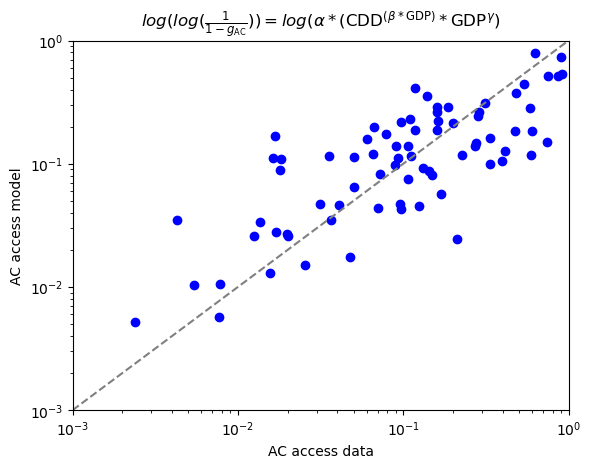

In [10]:
# Repeat the fit with the double log of the function

def ac_access_combined_exp_log_log(xdata, a, b, c):
    return np.log(ac_access_log(xdata, a, b, c))

popt_comb_log_log, pcov_comb_log_log = curve_fit(ac_access_combined_exp_log_log, xdata, np.log(np.log(1/(1-ydata))), bounds=(0, np.inf))
print("Fit parameters for AC access combined exponential")
print("alpha = ", popt_comb_log_log[0], "beta = ", popt_comb_log_log[1], "gamma = ", popt_comb_log_log[2], "\n")

# Calculate fit diagnostics
fit_diagnostics(np.log(np.log(1/(1-ydata))), ac_access_combined_exp_log_log(xdata, *popt_comb_log_log), popt_comb_log_log, pcov_comb_log_log, "AC access double log of combined exponential")
# Plot the AC access data vs model
plot_ac_access((ydata), (1.-np.exp(-1*ac_access_log(xdata, *popt_comb_log_log))), "blue", r"$log(log(\frac{1}{1-g_{\mathrm{AC}}}))= log(\alpha * (\mathrm{CDD}^{(\beta*\mathrm{GDP})} * \mathrm{GDP}^{\gamma})})))$", "ac_access_combined_exp_log_log")

In [11]:
print(1.-np.exp(np.exp(-1*ac_access_log(xdata, *popt_comb_log_log))))

0     -0.616055
1     -0.867678
3     -1.154256
4     -0.750593
5     -1.196279
         ...   
120   -1.092253
121   -1.252000
122   -1.363032
123   -1.316912
124   -1.547826
Length: 76, dtype: float64
